In [3]:
import joblib
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GTFS import LINKED_TRIP_GROUPS, TIME_COLS
from matplotlib import dates
from datetime import datetime


UNIQUE_COLUMN_SET = ["trip_id", "date", "service_id", "block_id"]
REGRESSION_MODEL_PATH = "models/power_consumption_linear_regression.sav"
DESIGN_MATRIX_PATH = "datasets/design_matrix.csv"
WAYNE_TRIPS_PATH = "datasets/wayne_trips_to_PA.pkl"
TEMP_PATH = "datasets/Temperature.csv"
WAYNE_COLS = ["service_id", "block_id", "trip_id", "shape_dist_traveled", "duration", "time_waiting"]
BUS_BATTERY_CAPACITY = 364
MODEL = joblib.load(REGRESSION_MODEL_PATH)
RANDOM_STATE = 42
STATE = np.random.RandomState(RANDOM_STATE)


wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / 3600)
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / row.duration_hours, axis=1)
services = pd.read_csv("gtfs/calendar_dates.txt", parse_dates=["date"], usecols=["date", "service_id"])
wayne_trips = wayne_trips.merge(services, on="service_id")


def assert_is_unique(df):
    assert df.groupby(UNIQUE_COLUMN_SET).filter(lambda x: len(x) > 1).shape[0] == 0


assert_is_unique(wayne_trips)


In [5]:
M = pd.read_csv(DESIGN_MATRIX_PATH)
temps = pd.read_csv(TEMP_PATH)
X1 = temps["Temp_avg"]
X2 = X1 ** 2
X3 = M["Speed"]

# Create bootstrap distribution
B, X3_stdev = wayne_trips.shape[0] * 50, np.std(X3)
bootstrap_wayne = wayne_trips.sample(n=B, replace=True, random_state=RANDOM_STATE)
bootstrap_wayne["temperature"] = STATE.choice(X1, B, replace=True)
bootstrap_wayne["temp_sq"] = bootstrap_wayne.temperature ** 2
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed.apply(lambda x: STATE.normal(loc=x, scale=X3_stdev))
bootstrap_wayne["speed"] = bootstrap_wayne.avg_speed
bootstrap_wayne["predicted_consumption_kW"] = MODEL.predict(bootstrap_wayne[["temperature", "temp_sq", "speed"]])
bootstrap_wayne["predicted_consumption_kWh"] = bootstrap_wayne.predicted_consumption_kW * bootstrap_wayne.duration_hours
bootstrap_wayne["rank"] = bootstrap_wayne.groupby(["date", "trip_id", "block_id", "service_id"])["predicted_consumption_kW"].rank(method="dense")


In [6]:
# Group by date, service_id, block_id, rank to get distribution of total predicted kWh per date-service-block
date_service_block_dists = bootstrap_wayne.groupby(["date", "service_id", "block_id", "rank"])["predicted_consumption_kWh"].sum()
date_service_block_99th = date_service_block_dists.reset_index().groupby(["date", "service_id", "block_id"])["predicted_consumption_kWh"].quantile(q=0.99).reset_index()

# Is date service block incomplete
date_service_block_99th["date_service_block_is_incomplete"] = (date_service_block_99th.predicted_consumption_kWh > BUS_BATTERY_CAPACITY).astype(int)
date_service_block_99th["date_service_block_kWh_deficit"] = date_service_block_99th.predicted_consumption_kWh - BUS_BATTERY_CAPACITY
date_service_block_99th.date_service_block_kWh_deficit = date_service_block_99th.date_service_block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)
date_service_block_99th.head()

# Join block info back onto trip info
wayne_trips_dates = wayne_trips.merge(date_service_block_99th, on=["block_id", "service_id", "date"])
assert_is_unique(wayne_trips_dates)

# Write to pickle
date_service_block_99th.to_pickle("datasets/date_service_block_prediction_kWh.pkl")


<Axes: xlabel='predicted_consumption_kW', ylabel='Density'>

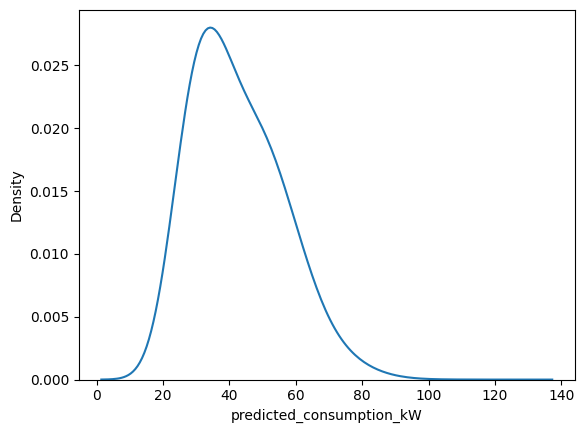

In [8]:
sns.kdeplot(bootstrap_wayne.predicted_consumption_kW, bw_adjust=10)


In [55]:
date_kWh_deficits = date_service_block_99th.groupby("date")[["date_service_block_kWh_deficit", "date_service_block_is_incomplete"]].sum().reset_index()
date_kWh_deficits["num_buses"] = np.ceil(date_kWh_deficits.date_service_block_kWh_deficit / BUS_BATTERY_CAPACITY)
date_kWh_deficits = date_kWh_deficits.sort_values(by="num_buses", ascending=False)
date_kWh_deficits.describe()


,date,date_service_block_kWh_deficit,date_service_block_is_incomplete,num_buses
count,180,180.000000,180.000000,180.000000
mean,2023-10-20 12:00:00,1397.919674,17.622222,4.338889
min,2023-07-23 00:00:00,608.468053,11.000000,2.000000
25%,2023-09-05 18:00:00,975.199353,14.000000,3.000000
50%,2023-10-20 12:00:00,1122.349604,16.000000,4.000000
75%,2023-12-04 06:00:00,2072.548147,19.250000,6.000000
max,2024-01-18 00:00:00,2767.685644,33.000000,8.000000
std,NaN,590.553649,5.061803,1.708225


In [10]:
# Get date-service-block length
date_service_block_length = wayne_trips_dates.groupby(["date"] + LINKED_TRIP_GROUPS)["trip_id"].count()
date_service_block_length = date_service_block_length.reset_index().rename({"trip_id": "num_trips"}, axis=1)
date_service_block_length.describe()


,date,service_id,num_trips
count,65282,65282.000000,65282.000000
mean,2023-10-20 17:58:41.252412672,3.404828,2.163414
min,2023-07-23 00:00:00,1.000000,1.000000
25%,2023-09-06 00:00:00,3.000000,1.000000
50%,2023-10-20 00:00:00,3.000000,2.000000
75%,2023-12-05 00:00:00,4.000000,3.000000
max,2024-01-18 00:00:00,7.000000,7.000000
std,NaN,0.755095,1.426866


In [11]:
wayne_trips_dates = wayne_trips_dates.merge(date_service_block_length, on=["date"] + LINKED_TRIP_GROUPS)
wayne_trips_dates.head()


,service_id,block_id,trip_id,shape_dist_traveled,duration,time_waiting,duration_hours,avg_speed,date,predicted_consumption_kWh,date_service_block_is_incomplete,date_service_block_kWh_deficit,num_trips
0,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.050000,20.786476,2023-07-29,385.50419,1,21.50419,6
1,1,160WY001,7930,22.2051,0 days 01:02:00,0 days 00:43:00,1.033333,21.488806,2023-07-29,385.50419,1,21.50419,6
2,1,160WY001,7917,21.8258,0 days 01:19:00,0 days 00:21:00,1.316667,16.576557,2023-07-29,385.50419,1,21.50419,6
3,1,160WY001,7933,22.2051,0 days 01:08:00,0 days 00:27:00,1.133333,19.592735,2023-07-29,385.50419,1,21.50419,6
4,1,160WY001,7920,21.8258,0 days 01:19:00,0 days 00:21:00,1.316667,16.576557,2023-07-29,385.50419,1,21.50419,6


In [12]:
assert_is_unique(wayne_trips_dates)

wayne_trips_dates["trip_predicted_consumption_kWh"] = wayne_trips_dates.predicted_consumption_kWh / wayne_trips_dates.num_trips

# Add field to calculate the max charging per the schedule
pa_stops = pd.read_pickle("datasets/wayne_trips_to_PA.pkl")[["trip_id", "is_port_authority_stop", "final_departure_time", "first_arrival_time"]]
wayne_trips_dates = wayne_trips_dates.merge(pa_stops, on=["trip_id"])

assert_is_unique(wayne_trips_dates)

wayne_trips_dates["max_charging_kWh"] = wayne_trips_dates.apply(lambda row: (row.time_waiting.total_seconds() / 3600) * (0.9*220) if row.is_port_authority_stop else 0, axis=1)
wayne_trips_dates.head()


,service_id,block_id,trip_id,shape_dist_traveled,duration,time_waiting,duration_hours,avg_speed,date,predicted_consumption_kWh,date_service_block_is_incomplete,date_service_block_kWh_deficit,num_trips,trip_predicted_consumption_kWh,is_port_authority_stop,final_departure_time,first_arrival_time,max_charging_kWh
0,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-07-29,385.504190,1,21.50419,6,64.250698,1,0 days 07:23:00,0 days 06:20:00,89.1
1,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-05,362.325181,0,0.00000,6,60.387530,1,0 days 07:23:00,0 days 06:20:00,89.1
2,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-12,359.799728,0,0.00000,6,59.966621,1,0 days 07:23:00,0 days 06:20:00,89.1
3,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-19,360.198399,0,0.00000,6,60.033066,1,0 days 07:23:00,0 days 06:20:00,89.1
4,1,160WY001,7914,21.8258,0 days 01:03:00,0 days 00:27:00,1.05,20.786476,2023-08-26,348.791006,0,0.00000,6,58.131834,1,0 days 07:23:00,0 days 06:20:00,89.1


In [13]:
wayne_trips_dates = wayne_trips_dates.sort_values(by=["date"] + LINKED_TRIP_GROUPS + ["final_departure_time", "first_arrival_time"])

assert_is_unique(wayne_trips_dates)

# Get the rolling consumption
rolling_stats = wayne_trips_dates.groupby(["date"] + LINKED_TRIP_GROUPS)["trip_predicted_consumption_kWh"].expanding(1).sum().reset_index(level=[0, 1, 2])
rolling_stats = rolling_stats.rename({"trip_predicted_consumption_kWh": "rolling_consumption"}, axis=1)
rolling_stats.head()


,date,block_id,service_id,rolling_consumption
10400,2023-07-23,160WY001,2,80.352940
10426,2023-07-23,160WY001,2,160.705880
10452,2023-07-23,160WY002,2,101.735599
10478,2023-07-23,160WY002,2,203.471198
10504,2023-07-23,160WY003,2,88.805854


In [20]:
# Add rank to rolling

rolling_stats["rank"] = rolling_stats.groupby(["date"] + LINKED_TRIP_GROUPS)["rolling_consumption"].rank(method="dense")

wayne_trips_dates["rank"] = wayne_trips_dates.groupby(["date"] + LINKED_TRIP_GROUPS)["final_departure_time"].rank(method="dense")
wayne_trips_dates = wayne_trips_dates.sort_values(by=["date", "service_id", "block_id", "final_departure_time"])
wayne_trips_dates.head()

wayne_trips_rolling = wayne_trips_dates.merge(rolling_stats, on=["date", "rank"] + LINKED_TRIP_GROUPS)

assert_is_unique(wayne_trips_rolling)


In [39]:
# Add capacity less consumption & net capacity after charge

wayne_trips_rolling["capacity_less_consump"] = BUS_BATTERY_CAPACITY - wayne_trips_rolling["rolling_consumption"]
wayne_trips_rolling["current_trip_capacity_loss"] = wayne_trips_rolling["trip_predicted_consumption_kWh"] 
wayne_trips_rolling["current_charge_loss_diff"] = wayne_trips_rolling.max_charging_kWh - wayne_trips_rolling.current_trip_capacity_loss
wayne_trips_rolling["net_capacity_after_charge"] = wayne_trips_rolling.apply(lambda row: min(BUS_BATTERY_CAPACITY, row.capacity_less_consump + row.max_charging_kWh), axis=1)
wayne_trips_rolling.head()


#still_incomplete = wayne_trips_rolling[wayne_trips_rolling.net_capacity_after_charge < 0]
#wayne_trips_dates.to_csv("datasets/wayne_trips_capacity_analysis.csv", index=False)


def get_net_capacity(group_of_rows):
    current_capacity = BUS_BATTERY_CAPACITY
    for index, value in group_of_rows.iterrows():
        current_capacity = min(BUS_BATTERY_CAPACITY, current_capacity + value.current_charge_loss_diff)
    return current_capacity


print(get_net_capacity(wayne_trips_rolling.iloc[0:2, :]))
print(364 - 80.35294)

283.64706017350994
283.64706


In [53]:
# Apply get_net_capacity to each date, block, service
net_capacities = wayne_trips_rolling.groupby(["date"] + LINKED_TRIP_GROUPS).apply(get_net_capacity).reset_index()
net_capacities = net_capacities.rename({0: "net_capacity"}, axis=1)
incomplete = net_capacities[net_capacities.net_capacity < 0]
incomplete_by_date = incomplete.groupby("date").agg({"net_capacity": "sum", "block_id": "count"}).reset_index()
incomplete_by_date["num_buses"] = np.ceil(np.abs(incomplete_by_date.net_capacity) / BUS_BATTERY_CAPACITY).astype(int)
incomplete_by_date = incomplete_by_date.sort_values(by="net_capacity", ascending=True)
incomplete_by_date


,date,net_capacity,block_id,num_buses
113,2023-11-19,-626.260710,5,2
4,2023-07-27,-539.023645,5,2
7,2023-07-30,-488.492755,4,2
85,2023-10-22,-482.693183,4,2
73,2023-10-08,-470.206592,5,2
...,...,...,...,...
80,2023-10-17,-5.821906,1,1
133,2023-12-09,-5.101268,2,1
115,2023-11-21,-3.599645,1,1
145,2023-12-21,-3.561067,1,1


In [26]:

still_incomplete.groupby(["date"] + LINKED_TRIP_GROUPS)["trip_id"].count().reset_index().groupby("date")["block_id"].count().max()


33

In [38]:

# Change the max charging to be the lower of predicted consumption and max_charging_kWh
trip_deficits["max_charging_kWh"] = trip_deficits.apply(lambda row: min(row.max_charging_kWh, row.predicted_consumption_99th), axis=1)

# Group by service ID & block ID rolling sum of consumption and charging
rolling_stats = trip_deficits.groupby(LINKED_TRIP_GROUPS)[["predicted_consumption_99th", "max_charging_kWh"]].expanding(1).sum().reset_index(level=[0,1])

# Net consumption is consumption - charge
rolling_stats["net_consumption"] = rolling_stats.predicted_consumption_99th - rolling_stats.max_charging_kWh

# Net capacity is BUS_BATTER_CAPACITY - net_consumption
rolling_stats["net_capacity"] = BUS_BATTERY_CAPACITY - rolling_stats["net_consumption"]
trip_deficits["net_capacity"] = rolling_stats.net_capacity

# Show those block-service combinations that have negative net capacity
negative_net_capacity = rolling_stats[rolling_stats.net_capacity < 0][LINKED_TRIP_GROUPS].drop_duplicates()

# Join these service-blocks onto trip_deficits
trip_deficits = trip_deficits.merge(negative_net_capacity, on=LINKED_TRIP_GROUPS, how="left", indicator=True)

# Add indicator for whether or not service block has insufficient charge
trip_deficits["is_insufficient_charge"] = trip_deficits["_merge"].apply(lambda x: 1 if x == "both" else 0)

# Drop columns & rename
trip_deficits = trip_deficits.drop(["_merge", "time_waiting"], axis=1)
trip_deficits = trip_deficits.rename({"is_port_authority_stop": "is_PA_stop"}, axis=1)

# Only those trips whose service-block charge is insufficient
insufficient_service_blocks = trip_deficits[trip_deficits.is_insufficient_charge == 1].copy()


<Axes: xlabel='hour', ylabel='net_capacity'>

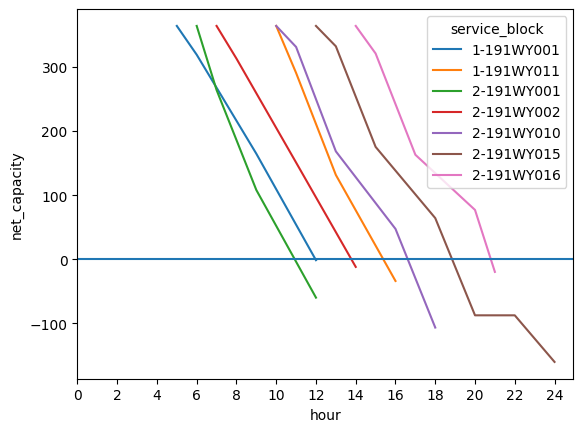

In [39]:
insufficient_service_blocks["service_block"] = insufficient_service_blocks.service_id.astype(str).str.cat(insufficient_service_blocks.block_id, sep="-")

# Convert the interval to a datetime from timedelta
insufficient_service_blocks["hour"] = insufficient_service_blocks.final_departure_time.apply(lambda x: x.total_seconds() // 3600)
insufficient_service_blocks["hour"]

# Some quick magic
y = insufficient_service_blocks.groupby("service_block")["hour"].min().to_dict()

new_entries = pd.concat([pd.DataFrame({"service_block": key, "hour": value - 1, "net_capacity": BUS_BATTERY_CAPACITY}, index=[str(key) + str(value)]) for key, value in y.items()])

insufficient_service_blocks = pd.concat([new_entries, insufficient_service_blocks])


graph = sns.lineplot(data=insufficient_service_blocks, x="hour", y="net_capacity", hue="service_block")
graph.axhline(0)

graph.set_xticks(range(0, 25, 2))
graph


In [10]:
wayne_trips = pd.read_pickle(WAYNE_TRIPS_PATH)[WAYNE_COLS]
wayne_trips["duration_hours"] = wayne_trips.duration.apply(lambda x: x.total_seconds() / (60*60))
wayne_trips["avg_speed"] = wayne_trips.apply(lambda row: row.shape_dist_traveled / (row.duration_hours), axis=1)

# Do prediction given temp of 7.7 degrees F
wayne_trips["temp_1th_pred_kW"] = wayne_trips.apply(lambda x: x.avg_speed*1.55 - 1.48*7.7 + 0.0105*7.7**2, axis=1)
wayne_trips["temp_1th_pred_kWh"] = wayne_trips.duration_hours * wayne_trips.temp_1th_pred_kW

# Get sums by block ID
blocks_total_kWh = wayne_trips.groupby("block_id")["temp_1th_pred_kWh"].sum().reset_index()
blocks_total_kWh["block_is_incomplete"] = (blocks_total_kWh.temp_1th_pred_kWh > BUS_BATTERY_CAPACITY).astype(int)
blocks_total_kWh["block_kWh_deficit"] = blocks_total_kWh.temp_1th_pred_kWh - BUS_BATTERY_CAPACITY
blocks_total_kWh.block_kWh_deficit = blocks_total_kWh.block_kWh_deficit.apply(lambda x: 0 if x < 0 else x)

# Join block info back onto trip info
wayne_trips = wayne_trips.merge(blocks_total_kWh, on="block_id")

# Get the num of buses needed
service_id_deficits = wayne_trips.groupby("service_id")[["block_is_incomplete", "block_kWh_deficit"]].sum().reset_index()
service_id_deficits["num_buses"] = np.ceil(service_id_deficits.block_kWh_deficit / BUS_BATTERY_CAPACITY)


In [11]:
missing_capacity = abs(int(insufficient_service_blocks.groupby(LINKED_TRIP_GROUPS)["net_capacity"].nth([-1]).sum()))
buses_required = int(np.ceil(abs(missing_capacity) / BUS_BATTERY_CAPACITY))
print(f"The number of buses required is {buses_required} for a capacity deficit of {missing_capacity} kWh")


The number of buses required is 2 for a capacity deficit of 392 kWh


In [13]:
num_trips = wayne_trips.trip_id.nunique()
num_blocks = wayne_trips.block_id.nunique()
num_services = wayne_trips.service_id.nunique()
num_service_blocks = wayne_trips[LINKED_TRIP_GROUPS].drop_duplicates().shape[0]

print(f"There are {num_trips} trips across {num_blocks} blocks and {num_services} service days. There are {num_service_blocks} total service blocks.")

There are 2265 trips across 358 blocks and 7 service days. There are 896 total service blocks.


In [17]:
wayne_trips_to_PA["is_port_authority_stop"].sum()

1153

In [26]:
service_block_consumption = trip_deficits.groupby(LINKED_TRIP_GROUPS)["predicted_consumption_99th"].sum().reset_index()

,block_id,service_id,predicted_consumption_99th
0,160WY001,1,408.562892
1,160WY001,2,125.885050
2,160WY001,4,118.000411
3,160WY001,5,116.807969
4,160WY002,1,349.057157
...,...,...,...
891,194WY038,3,182.378718
892,194WY039,3,237.780332
893,194WY040,3,351.078289
894,194WY041,3,96.426059


In [30]:
blocks_total_kWh.groupby("service_id").agg({"block_is_incomplete": ["sum", "count", "mean"]})


block_is_incomplete                
                           sum count      mean
service_id                                    
1                           41    99  0.414141
2                           33    72  0.458333
3                            7   222  0.031532
4                            7   248  0.028226
5                            7   249  0.028112
6                            0     2  0.000000
7                            0     4  0.000000

In [31]:
trip_deficits.head()

,block_id,service_id,trip_id,is_PA_stop,block_kWh_deficit,first_arrival_time,final_departure_time,shape_dist_traveled,predicted_consumption_99th,max_charging_kWh,net_capacity,is_insufficient_charge
0,160WY001,1,7914,1,44.562892,0 days 06:20:00,0 days 07:23:00,21.8258,66.429714,66.429714,364.000000,0
1,160WY001,1,7930,0,44.562892,0 days 07:50:00,0 days 08:52:00,22.2051,63.534061,0.000000,300.465939,0
2,160WY001,1,7917,1,44.562892,0 days 09:35:00,0 days 10:54:00,21.8258,69.559705,69.300000,300.206234,0
3,160WY001,1,7933,0,44.562892,0 days 11:15:00,0 days 12:23:00,22.2051,69.986588,0.000000,230.219646,0
4,160WY001,1,7920,1,44.562892,0 days 12:50:00,0 days 14:09:00,21.8258,70.869476,69.300000,228.650170,0
